In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [ ]:
data = []

pattern = r'Configuration: \{"goal": "navigate_to_gate \((?P<goal>.*?)\)"[^}]*\}. Negotiation time: (?P<time>\d+\.\d+) seconds. Rounds: (?P<rounds>\d+). Result: (?P<result>\S+)'

sim_files = [os.path.join('../results', f) for f in os.listdir('../results') if f.startswith('simulation-')] # and (f.endswith('2.log') or f.endswith('pc.log'))]

for log_file_path in sim_files:
    with open(log_file_path, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                config = match.group("goal")
                rounds = int(match.group("rounds")) // 2 + (int(match.group("rounds")) % 2 > 0)
                time = float(match.group("time"))
                result = match.group("result")
                setting = re.search(r'simulation-(.*).log', log_file_path).group(1)
                data.append({"configuration": config, "rounds": rounds, "negotiation_time": time, "result": result, "setting": setting})

df = pd.DataFrame(data)
df.head()

,configuration,rounds,negotiation_time,result,setting
0,"User: A, Negotiating against: B",5,0.568,no-agreement,onrobot
1,"User: A, Negotiating against: C",7,0.682,no-agreement,onrobot
2,"User: A, Negotiating against: D",8,0.742,loser,onrobot
3,"User: A, Negotiating against: E",8,0.783,loser,onrobot
4,"User: A, Negotiating against: F",5,0.578,loser,onrobot


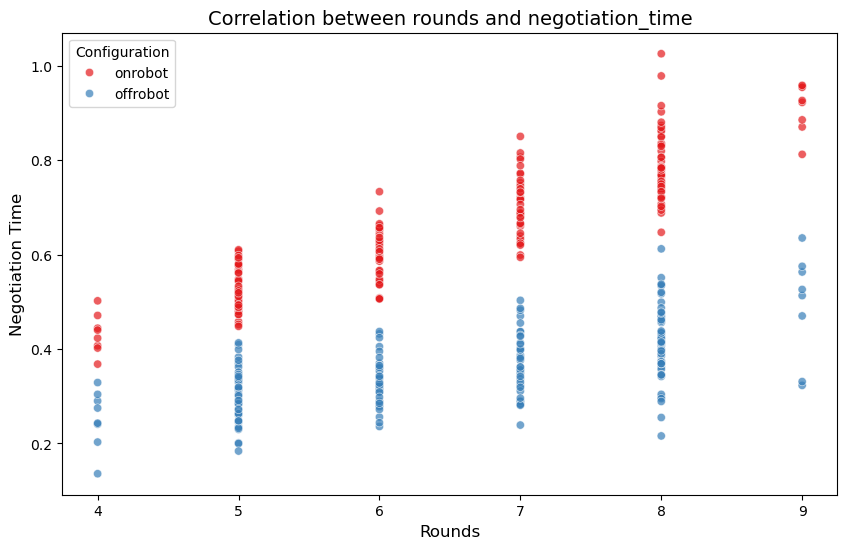

In [3]:
plt.figure(figsize=(10, 6))

plotting_df = df

sns.scatterplot(data=plotting_df, x='rounds', y='negotiation_time', hue='setting', palette='Set1', alpha=0.7)

plt.title("Correlation between rounds and negotiation_time", fontsize=14)
plt.xlabel("Rounds", fontsize=12)
plt.ylabel("Negotiation Time", fontsize=12)
plt.legend(title="Configuration", fontsize=10)

plt.show()

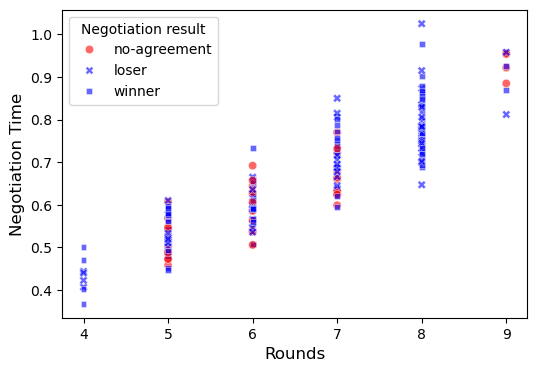

In [4]:
plt.figure(figsize=(6, 4))

onrobot_df = df[df['setting'] == 'onrobot']

sns.scatterplot(data=onrobot_df, x='rounds', y='negotiation_time', hue='result', style='result', palette={'no-agreement': 'red', 'winner': 'blue', 'loser': 'blue'}, alpha=0.6)

plt.xlabel("Rounds", fontsize=12)
plt.ylabel("Negotiation Time", fontsize=12)
plt.legend(title="Negotiation result", fontsize=10)

plt.show()


In [5]:
long_negotiations = onrobot_df[onrobot_df['negotiation_time'] > 0.8]

num_long_negotiations = long_negotiations.shape[0]

total_onrobot_cases = onrobot_df.shape[0]
percentage_long_negotiations = (num_long_negotiations / total_onrobot_cases) * 100

print(f"Negotiation completed in more than 0.8 seconds: {num_long_negotiations}")
print(f"Percentage: {percentage_long_negotiations:.2f}%")
print("\nCases:")
print(long_negotiations)

Negotiation completed in more than 0.8 seconds: 30
Percentage: 16.67%

Cases:
                       configuration  rounds  negotiation_time        result  \
20   User: C, Negotiating against: D       8             0.873         loser   
21   User: C, Negotiating against: E       8             0.835         loser   
23   User: C, Negotiating against: G       7             0.850         loser   
24   User: C, Negotiating against: H       7             0.806         loser   
27   User: D, Negotiating against: A       8             0.850        winner   
28   User: D, Negotiating against: B       8             0.864        winner   
29   User: D, Negotiating against: C       8             0.902        winner   
30   User: D, Negotiating against: E       9             0.956  no-agreement   
31   User: D, Negotiating against: F       8             0.819        winner   
32   User: D, Negotiating against: G       8             0.861        winner   
33   User: D, Negotiating against: H      

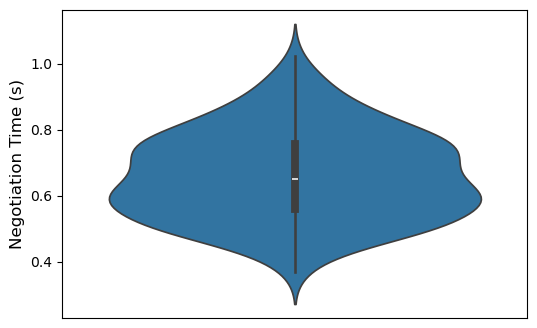

In [6]:
plt.figure(figsize=(6, 4))

onrobot_df = df[df['setting'] == 'onrobot']

sns.violinplot(data=onrobot_df, x='setting', y='negotiation_time')

plt.xlabel("")
plt.ylabel("Negotiation Time (s)", fontsize=12)

plt.xticks([])

plt.show()

In [7]:
# Stats
stats = df.groupby('setting').agg({
    #'rounds': ['mean', 'min', 'max', 'std'],
    'negotiation_time': ['mean', 'min', 'max', 'std']
})

print(stats)

         negotiation_time                        
                     mean    min    max       std
setting                                          
offrobot         0.358322  0.136  0.635  0.087307
onrobot          0.661667  0.368  1.025  0.135784


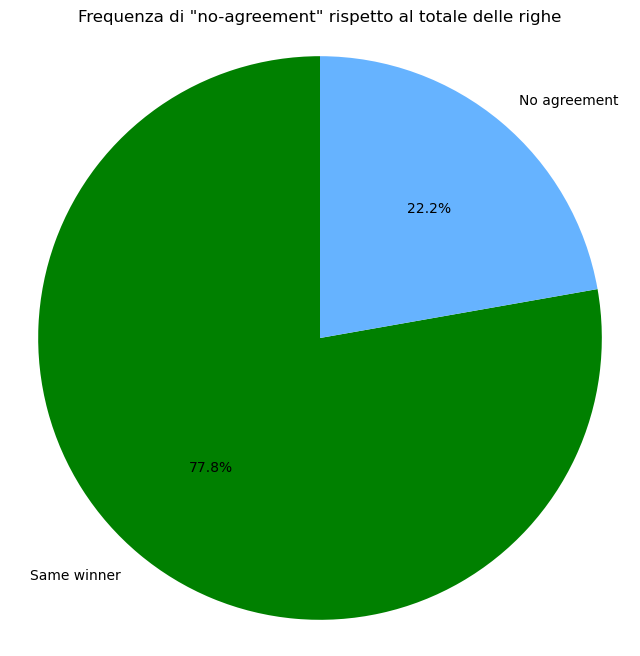

Same winner: 140 / 180 (77.78%)


In [8]:
sim_res_df = df[df['setting'] == 'onrobot']

result_count = sim_res_df[sim_res_df['result'] != 'no-agreement'].shape[0]
total_count = sim_res_df.shape[0]

labels = ['Same winner', 'No agreement']
sizes = [result_count, total_count - result_count]
colors = ['green','#66b3ff']
explode = (0.1, 0)

plt.figure(figsize=(8, 8))
#plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Frequenza di "no-agreement" rispetto al totale delle righe')
plt.axis('equal')

plt.show()
print(f'Same winner: {result_count} / {total_count} ({result_count / total_count * 100:.2f}%)')

In [9]:
no_agreement_df = sim_res_df[(sim_res_df['result'] == 'no-agreement')]
winner_loser_df = sim_res_df[(sim_res_df['result'].isin(['winner', 'loser']))]

complete_stats = sim_res_df['negotiation_time'].describe()

no_agreement_stats = no_agreement_df['negotiation_time'].describe()

winner_loser_stats = winner_loser_df['negotiation_time'].describe()

print("Overall stats:")
print(complete_stats)

print("\nWhen negotiation ends with agreement:")
print(winner_loser_stats)

print("\nWhen no agreement is reached:")
print(no_agreement_stats)


Overall stats:
count    180.000000
mean       0.661667
std        0.135784
min        0.368000
25%        0.560500
50%        0.652000
75%        0.758500
max        1.025000
Name: negotiation_time, dtype: float64

When negotiation ends with agreement:
count    140.000000
mean       0.670907
std        0.137145
min        0.368000
25%        0.566000
50%        0.682000
75%        0.773750
max        1.025000
Name: negotiation_time, dtype: float64

When no agreement is reached:
count    40.000000
mean      0.629325
std       0.127304
min       0.458000
25%       0.540000
50%       0.615500
75%       0.681250
max       0.956000
Name: negotiation_time, dtype: float64
